# Our Work
1. We tried using Deep learning Neural Network to estimate Beta Distribution and Gamma Distribution

2. We tried using Mixture of Gaussian to estimate Beta and Gamma distribution

3. We compare the Effect of Single Gaussian and Mixture Gaussian, it shows that The mixture of Gaussian performs better than single.

4. We tried using Beta to estimate Beta, the results show that thay highly match

### Using Single Gaussian to estimate Beta with different y_obs

We import the packages required and define our DNN
The input is y that we simulate, it is 1-dimensional.
It has 3 hidden Layers:

Layer 1: Fully connected (Linear) with 24 neurons + ReLU 

Layer 2: Fully connected with 25 neurons + ReLU

Layer 3: Fully connected with 16 neurons + ReLU

Output Layer: 2 neurons with no activation:

The first output (mu) models the predicted mean.

The second output (log_sigma) represents the logarithm of the predicted standard deviation to ensure it remains positive after exponentiation.

In [2]:
from scipy.stats import norm, poisson, beta, binom
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

# Define the deep neural network
class ProbabilisticNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 24),
            nn.ReLU(),
            nn.Linear(24 ,25),
            nn.ReLU(),
            nn.Linear(25, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        out = self.net(x)
        mu = out[:, 0:1]
        log_sigma = out[:, 1:2]  # Predict log(σ) to ensure positivity
        return mu, log_sigma


Now we simulate the Bayesian posterior of a binomial success probability parameter θ given observed data y∼Binomial(𝑛,𝜃), where θ comes from Beta distribution Beta(2.5)

In [4]:
# the prior is beta distribution
alpha = 2
beta_para = 5

# number of samples
M = 10**6

# binomial distribution
success = 80
n_trials = 100

# First sample theta form Beta(2,5)
theta_samples = beta.rvs(alpha, beta_para, size=M)
# Then for each theta, generate the binomial , also 

y_samples = binom.rvs(n=n_trials, p = theta_samples)

# Now you have (θ, x) pairs
# print("First 5 theta values:", theta_samples[:5])
# print("First 5 x values:", y_samples[:5])

theta_np = theta_samples.reshape(-1,1)
y_np = y_samples.reshape(-1,1)



- Construct joint samples theta, y{(i)} from the prior and likelihood:

$$
\theta^{(i)} \sim \text{Beta}(\alpha, \beta), \quad
y^{(i)} \sim \text{Binomial}(n, \theta^{(i)}), \quad i = 1, \dots, M.
$$

- Group the theta^{(i)} samples by their observed y^{(i)} values.

- Estimate the posterior moments of theta given each observed value y in 0, 1, ... , n:

$$
\mathbb{E}[\theta \mid y], \quad \text{Var}[\theta \mid y].
$$


Then we visualize how these quantities vary with the observed outcome 𝑦∈[0,100]


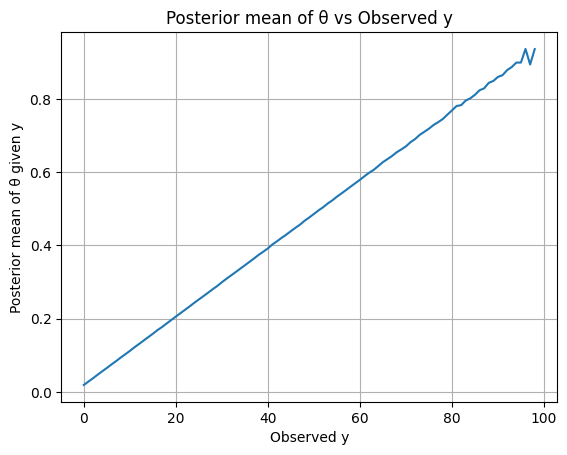

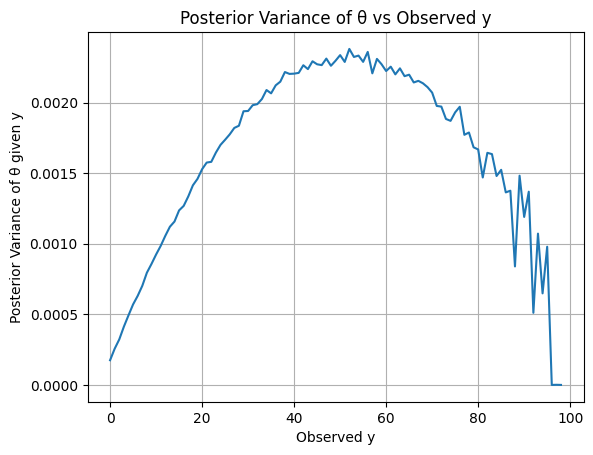

In [ ]:

# Combine  theta_np and y_np together
out_mat = np.column_stack([theta_samples, y_samples])
# Create a list of theta
theta_dict = defaultdict(list)
sel_index = (out_mat[:, 1] == 1) 
# print(sel_index)
for i in range(n_trials + 1):  # y ∈ [0, n_trials]
    sel_index = (out_mat[:, 1] == i)         # select rows where y == i
    theta_vals = out_mat[sel_index, 0]       # get corresponding θ
    theta_dict[i] = theta_vals               # store as list or array
# print(theta_dict)

# Now calculate the mean and variance of theta list
post_means = {}
post_vars = {}

for i in theta_dict:
    thetas = np.array(theta_dict[i])
    post_means[i] = np.mean(thetas)
    post_vars[i] = np.var(thetas)
    
# print(post_means)
# print(post_vars)


# Plot Expectatiion versus y
y_vals = list(range(n_trials + 1))  # y = 0 to 100
exp_vals = [post_means[y] for y in y_vals]

plt.plot(y_vals, exp_vals)
plt.xlabel("Observed y")
plt.ylabel("Posterior mean of θ given y")
plt.title("Posterior mean of θ vs Observed y")
plt.grid(True)
plt.show()



y_vals = list(range(n_trials + 1))  # y = 0 to 100
var_vals = [post_vars[y] for y in y_vals]

# Plot Var(\t)
plt.plot(y_vals, var_vals)
plt.xlabel("Observed y")
plt.ylabel("Posterior Variance of θ given y")
plt.title("Posterior Variance of θ vs Observed y")
plt.grid(True)
plt.show()


The plot 2 exhibits a near-linear relationship but quadratic while plot 1 shows quite linear.

We train a deep neural network to approximate the posterior distribution p(θ∣y), using supervised learning. Rather than learning a point estimate, 
the network learns to output the mean and variance of a Gaussian approximation to the posterior, for each observed 𝑦.

The Input is y, the output is μ and log(σ^2)/2

Now we use MSE loss, later we will use another loss function

Epoch 0, Loss: 71.44182
Epoch 100, Loss: 0.11176
Epoch 200, Loss: 0.10759
Epoch 300, Loss: 0.10703
Epoch 400, Loss: 0.10671
Epoch 500, Loss: 0.10715
Epoch 600, Loss: 0.11189
Epoch 700, Loss: 0.10888
Epoch 800, Loss: 0.10617
Epoch 900, Loss: 0.10533


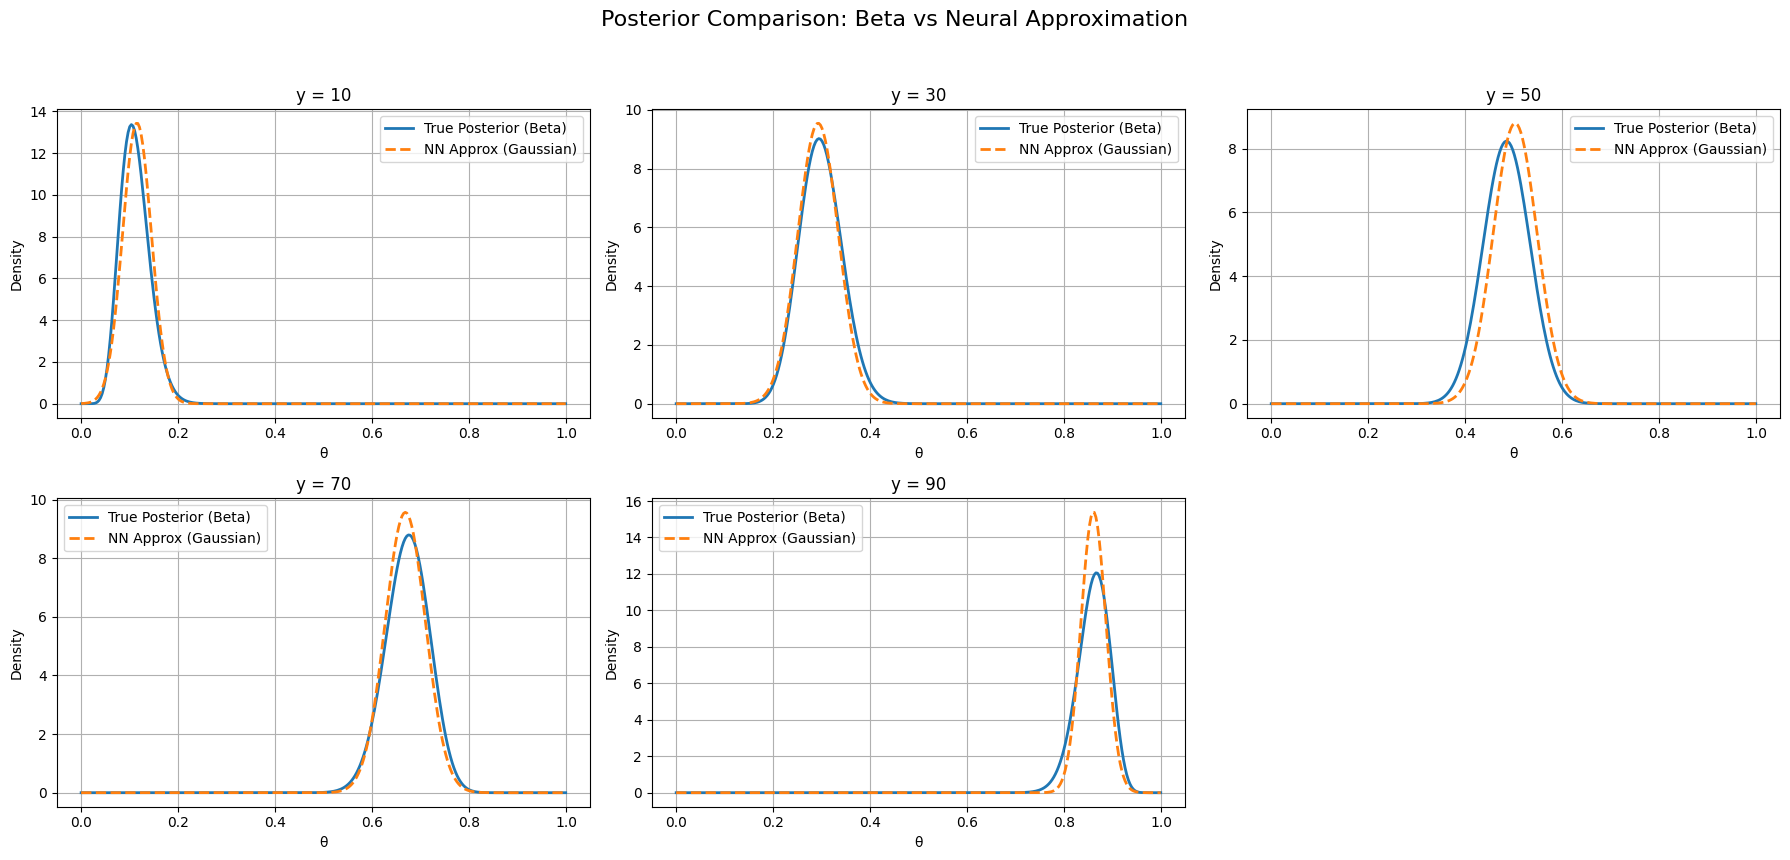

In [10]:

# conver t our post_mean and post variance into list 

x_list = []      # y values (input)
y_list = []      # [mean, log_variance] (output)
# var = post_vars[0]
# sigma = 0.5 * np.log(var)
# print(sigma)
for y_val in sorted(post_means.keys()):
    mu = post_means[y_val]
    var = post_vars[y_val]
    if var>0:
        # var = max(var, 1e-6)
        x_list.append([y_val])
        y_list.append([mu, 0.5 * np.log(var)])


x_np = np.array(x_list, dtype=np.float32)      # shape (N, 1)
y_np = np.array(y_list, dtype=np.float32)      # shape (N, 2)


x = torch.tensor(x_np, dtype=torch.float32)  # shape (N, 1)
y = torch.tensor(y_np, dtype=torch.float32)  # shape (N, 2)

# We use MSE loss
mse = nn.MSELoss()
        
model = ProbabilisticNN()
# Define what our optimizer is
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Extract training targets
y_target = y[:, 0:1]            # true mean
log_var_target = y[:, 1:2]      # true log variance


for epoch in range(1000):  # do 1000 passes over the data
    model.train()  # set model to training mode

    mu_pred, log_sigma_pred = model(x)  # forward pass: compute predictions

    loss_mu = mse(mu_pred, y_target)
    loss_logvar = mse(log_sigma_pred, log_var_target)
    loss = loss_mu + loss_logvar  # compute loss (MSE between prediction and true y)

    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # backpropagation: compute gradients
    optimizer.step()       # update weights using optimizer

    # Optional: print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")
        
        
#  Plot our training results
model.eval()
x_obs = torch.tensor([[50.0]], dtype=torch.float32)
mu_pred, log_sigma_pred = model(x_obs)

mu_val = mu_pred.item()
sigma_val = torch.exp(log_sigma_pred).item()

# print(f"Posterior for y=80 → N(mean={mu_val:.4f}, std={sigma_val:.4f})")


import matplotlib.pyplot as plt
import math

# Define y values to compare
y_obs_list = [10, 30, 50, 70, 90]  # Any length is fine

# Range of θ
theta_range = np.linspace(0.001, 0.999, 300)

# Grid layout: 3 columns, rows computed based on number of plots
n_cols = 3
n_rows = math.ceil(len(y_obs_list) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()  # Flatten to simplify indexing

for idx, y_obs in enumerate(y_obs_list):
    # True posterior
    true_posterior = beta(a=alpha + y_obs, b=beta_para + n - y_obs)
    true_pdf = true_posterior.pdf(theta_range)

    # NN approximation
    x_obs = torch.tensor([[y_obs]], dtype=torch.float32)
    mu_pred, log_sigma_pred = model(x_obs)
    mu_val = mu_pred.item()
    sigma_val = torch.exp(log_sigma_pred).item()
    approx_pdf = norm.pdf(theta_range, loc=mu_val, scale=sigma_val)

    # Plot on subplot
    ax = axes[idx]
    ax.plot(theta_range, true_pdf, label="True Posterior (Beta)", lw=2)
    ax.plot(theta_range, approx_pdf, label="NN Approx (Gaussian)", lw=2, linestyle="--")
    ax.set_title(f"y = {y_obs}", fontsize=12)
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(len(y_obs_list), n_rows * n_cols):
    fig.delaxes(axes[j])

# Overall layout
fig.suptitle("Posterior Comparison: Beta vs Neural Approximation", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Loss Function: Gaussian Negative Log-Likelihood on Posterior Samples

We now change our loss function to the negative log-likelihood (NLL) of a Gaussian model.  
Given a set of posterior samples \theta_1, ....., \theta_n for each observed y ,
we assume a neural network predicts the distribution:

$$
\theta \mid y \sim \mathcal{N}(\mu(y), \sigma(y)^2)
$$

Then the NLL loss over these samples is:

$$
\mathcal{L}_{\text{NLL}}(y, \{\theta_i\}) = \sum_{i=1}^n \left( \frac{1}{2} \log(2\pi) + \frac{1}{2} \log \sigma(y)^2 + \frac{(\theta_i - \mu(y))^2}{2 \sigma(y)^2} \right)
$$

In our implementation, we use the log-variance as model output:

$$
\log \sigma^2 = \texttt{log\_var}, \quad \sigma^2 = \exp(\texttt{log\_var})
$$

so the loss becomes:

$$
\mathcal{L}_{\text{NLL}} = \sum_{i=1}^n \left( \frac{1}{2} \log(2\pi) + \frac{1}{2} \cdot \texttt{log\_var} + \frac{(\theta_i - \mu)^2}{2 \cdot \exp(\texttt{log\_var})} \right)
$$

This allows the neural network to learn both the posterior mean and the uncertainty (variance), using only its own predictions.


### Train the model

In [11]:

# Define the deep neural network
class ProbabilisticNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4 ,1)
        )
        self.log_var_net = nn.Sequential(  # 
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        mu = self.mean_net(x)
        log_var = self.log_var_net(x)
        return mu, log_var  # Not var anymore, but log_var, more statble

# Define what our optimizer is
model = ProbabilisticNN()

optimizer = optim.Adam(model.parameters(), lr=0.01)


for epoch in range(1000):
    model.train()
    total_log_likelihood = 0.0

    for i in range(n_trials + 1):
        if post_vars[i] == 0:
            continue

        x_input = torch.tensor([[i / n_trials]], dtype=torch.float32)

        mu_pred, log_var_pred = model(x_input)
        var_pred = torch.exp(log_var_pred)

        theta_vals = torch.tensor(theta_dict[i], dtype=torch.float32).view(-1, 1)

        log_probs = -0.5 * (torch.log((torch.tensor(2 * torch.pi)) )
                            + log_var_pred 
                            + (theta_vals - mu_pred) 
                            ** 2 / var_pred)

        total_log_likelihood += log_probs.sum()

    loss = -total_log_likelihood

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")


Epoch 0, Loss: 1096999.37500
Epoch 100, Loss: -1756002.37500
Epoch 200, Loss: -1807962.25000
Epoch 300, Loss: -1812486.50000
Epoch 400, Loss: -1776276.87500
Epoch 500, Loss: -1816323.37500
Epoch 600, Loss: -1806966.87500
Epoch 700, Loss: -1817542.62500
Epoch 800, Loss: -1817222.75000
Epoch 900, Loss: -1818022.87500


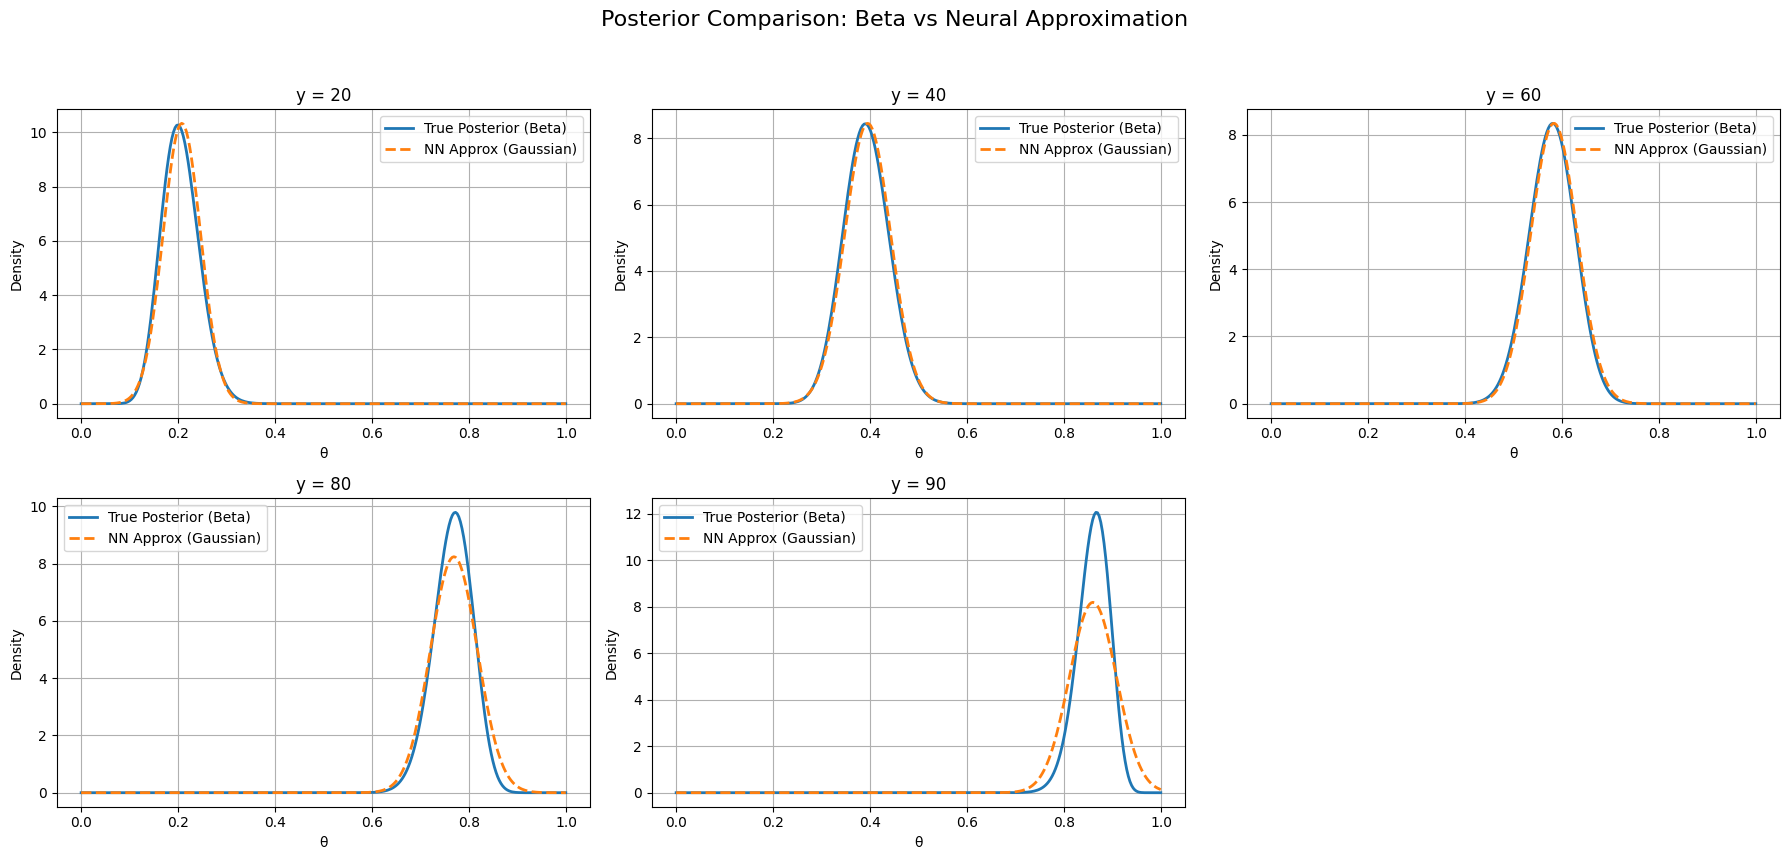

In [ ]:
import math
import matplotlib.pyplot as plt
from scipy.stats import beta, norm,gamma

# You can customize this list to test different observed y
y_obs_list = [20, 40, 60, 80, 90]
n_cols = 3
n_rows = math.ceil(len(y_obs_list) / n_cols)

theta_range = np.linspace(0.001, 0.999, 300)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for idx, y_obs in enumerate(y_obs_list):
    x_test = torch.tensor([[y_obs / n_trials]], dtype=torch.float32)

    with torch.no_grad():
        mu_pred, log_var_pred = model(x_test)
        var_pred = torch.exp(log_var_pred)
        mu_val = mu_pred.item()
        sigma_val = math.sqrt(var_pred.item())

    # True posterior: Beta(α + y, β + n - y)
    true_post = beta(a=alpha + y_obs, b=beta_para + n_trials - y_obs)
    true_pdf = true_post.pdf(theta_range)

    # NN approximation: N(μ, σ²)
    approx_pdf = norm.pdf(theta_range, loc=mu_val, scale=sigma_val)

    ax = axes[idx]
    ax.plot(theta_range, true_pdf, label="True Posterior (Beta)", lw=2)
    ax.plot(theta_range, approx_pdf, label="NN Approx (Gaussian)", lw=2, linestyle="--")
    ax.set_title(f"y = {y_obs}", fontsize=12)
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

# Hide any unused subplot
for j in range(len(y_obs_list), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Posterior Comparison: Beta vs Neural Approximation", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### DNN Inference for Gamma Using Gaussian


Parameters:
M  = 10^6
alpha_prior = 2 , beta_prior = 3
Appximated distribution = Single Gaussian with μ and σ^2


- We try Gamma distribution using DNN
- We set the parameters alpha <- 1 and beta <- 1 with number of pairs M <- 10^6
- sample thetas from rgamma(1, shape = alpha, rate = beta) and find the y_sum
- put them into matrix form
- Find the thetas for unique y_sum
- Now for each different y_sum , we find the pdf of the likelihood of theta
- Approximate Gamma distribution using Normal distribution of our mu_pred and var_pred



In [15]:
from scipy.stats import norm, poisson, beta, binom,gamma
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
# Define the deep neural network
class ProbabilisticNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4 ,1)
        )
        self.log_var_net = nn.Sequential(  # New part
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        mu = self.mean_net(x)
        log_var = self.log_var_net(x)
        return mu, log_var  # Not var anymore, but log_var, more statble
    
    
    
# the prior is Gamma distribution
alpha = 2
beta_para = 3

# number of samples
M = 10**6
#-------------------------------------------------------------------------------------------
# Gamma distribution

n_trials = 100

# First sample theta form Beta(2,5)
theta_samples = gamma.rvs(a = alpha, loc=0, scale = 1/beta_para, size=M)


# Broadcasting over theta_samples
y_samples = np.sum(poisson.rvs(mu=theta_samples[:, None], size=(len(theta_samples), n_trials)), axis=1)

# Now we have (θ, y_sum pairs
# print("First 5 theta values:", theta_samples[:5])
# print("First 5 x values:", y_samples[:5])

theta_np = theta_samples.reshape(-1,1)
y_np = y_samples.reshape(-1,1)


# Combine  theta_np and y_np together
out_mat = np.column_stack([theta_samples, y_samples])
# Create a list of theta

#----------------------------------------------------------------------------------------

theta_dict = defaultdict(list)
sel_index = (out_mat[:, 1] == 1) 
# Find the unique y_vals
unique_y_vals = np.unique(out_mat[:, 1])
# print(sel_index)
for y in unique_y_vals:
    sel_index = (out_mat[:, 1] == y)
    theta_vals = out_mat[sel_index, 0]
    theta_dict[y] = theta_vals



# Now calculate the mean and variance of theta list
post_means = {}
post_vars = {}

for i in theta_dict:
    if len(theta_dict[i]) >=2:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = np.var(thetas)
    elif len(theta_dict[i]) == 1:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = 0
    else:
        post_means[i] = 0
        post_vars[i] = 0
        


for key in theta_dict:
    if len(theta_dict[key]) == 0:
        theta_dict[key] = np.array([0.0])



# Define what our optimizer is
model = ProbabilisticNN()

optimizer = optim.Adam(model.parameters(), lr=0.01)

y_max = np.max(out_mat[:, 1]) # For normalization


for epoch in range(1000):
    model.train()
    total_log_likelihood = 0.0

    for y in unique_y_vals:
        if post_vars[y] == 0:
            continue
    
        x_input = torch.tensor([[y / y_max]], dtype=torch.float32)

        mu_pred, log_var_pred = model(x_input)
        var_pred = torch.exp(log_var_pred)

        theta_vals = torch.tensor(theta_dict[y], dtype=torch.float32).view(-1, 1)


        log_probs = -0.5 * (np.log(2 * np.pi) + log_var_pred + (theta_vals - mu_pred)**2 / var_pred)


        total_log_likelihood += log_probs.sum()

    loss = -total_log_likelihood

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")




Epoch 0, Loss: 1511334.12500
Epoch 100, Loss: -1162256.12500
Epoch 200, Loss: -1205087.37500
Epoch 300, Loss: -1206993.62500
Epoch 400, Loss: -1207172.87500
Epoch 500, Loss: -1207606.12500
Epoch 600, Loss: -1204011.25000
Epoch 700, Loss: -1215211.37500
Epoch 800, Loss: -1217913.12500
Epoch 900, Loss: -1221124.25000


### Plot the result of Gmmma Approximation

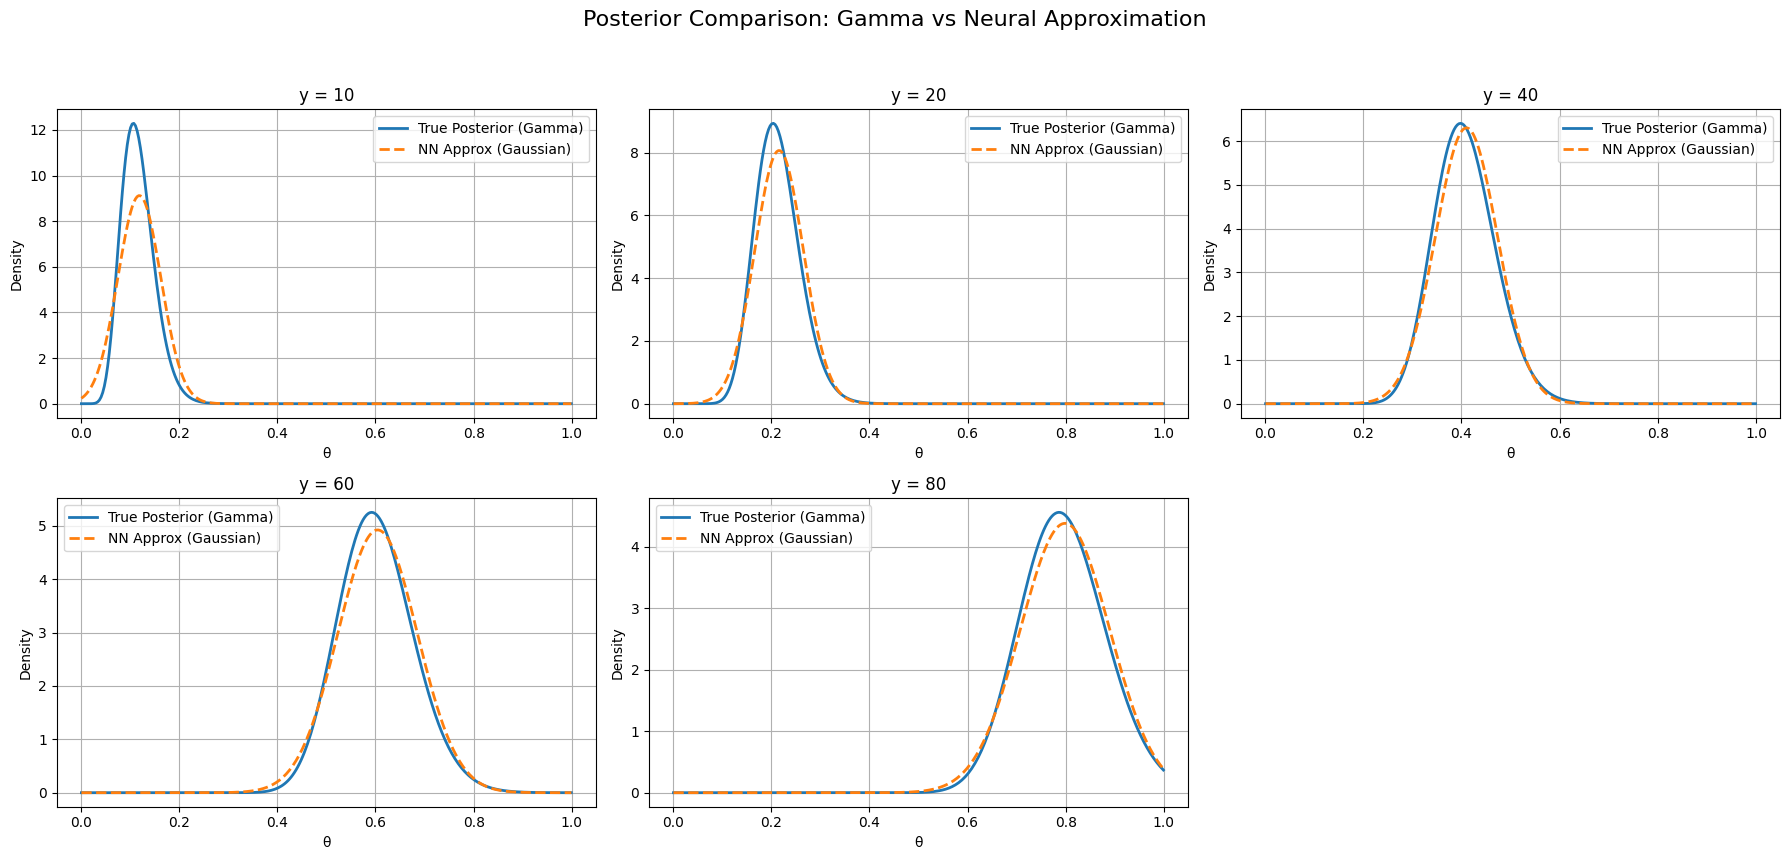

In [ ]:
import math
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Define the observed y values to compare
y_obs_list = [10, 20, 40, 60, 80]
n_cols = 3
n_rows = math.ceil(len(y_obs_list) / n_cols)

theta_range = np.linspace(0.001, 0.999, 300)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for idx, y_obs in enumerate(y_obs_list):
    x_test = torch.tensor([[y_obs / y_max]], dtype=torch.float32)

    with torch.no_grad():
        weights, mu, log_var = model(x_test)

    # True posterior: Gamma(α + y, scale = 1 / (β + n))
    true_post = gamma(a=alpha + y_obs, scale=1 / (beta_para + n_trials))
    true_pdf = true_post.pdf(theta_range)

    # Neural approximation: Gaussian(μ, σ²)
    approx_pdf = norm.pdf(theta_range, loc=mu_val, scale=sigma_val)

    ax = axes[idx]
    ax.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    ax.plot(theta_range, approx_pdf, label="NN Approx (Gaussian)", lw=2, linestyle="--")
    ax.set_title(f"y = {y_obs}", fontsize=12)
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(len(y_obs_list), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Posterior Comparison: Gamma vs Neural Approximation", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### DNN Inference for Beta Using Mixture_Gaussian


#### From Single Gaussian to Mixture of Gaussians: Improving Posterior Approximation

In previous sections, we used a neural network to learn a **single Gaussian distribution**:

$$
\mathcal{N}(\mu, \sigma^2)
$$

to approximate the posterior:

$$
p(\theta \mid y)
$$
Now we use Mixture Density Network (MDN)

The neural network now outputs:

$$
\begin{aligned}
&\text{- A set of mixture weights } \pi_1, \dots, \pi_K, \quad \text{where } \sum_{k=1}^{K} \pi_k = 1 \\
&\text{- A set of component means } \mu_1, \dots, \mu_K \\
&\text{- A set of component log-variances } \log \sigma_1^2, \dots, \log \sigma_K^2
\end{aligned}
$$

The predicted posterior becomes:

$$
p_{\text{NN}}(\theta \mid y) = \sum_{k=1}^{K} \pi_k(y) \cdot \mathcal{N}(\theta \mid \mu_k(y), \sigma_k^2(y))
$$

---

###  Loss Function: Negative Log-Likelihood of Mixture Model

Given a set of posterior samples \( \{\theta_i\}_{i=1}^N \) for a specific observed \( y \), we define the loss as:

$$
\mathcal{L}_{\text{Mixture}}(y) = - \frac{1}{N} \sum_{i=1}^{N} \log \left[ \sum_{k=1}^{K} \pi_k(y) \cdot \mathcal{N}(\theta_i \mid \mu_k(y), \sigma_k^2(y)) \right]
$$




In [ ]:
from scipy.stats import norm, poisson, beta, binom
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import random

# Set seed value
SEED = 123
random.seed(SEED)         # Python random
np.random.seed(SEED)      # NumPy random
torch.manual_seed(SEED)   # PyTorch random

# For reproducibility (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the deep neural network
class MixtureDensityNN(nn.Module):
    def __init__(self, K=8):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(1, 24),
            nn.ReLU(),
            nn.Linear(24 ,25),
            nn.ReLU(),
            nn.Linear(25, 16),
            nn.ReLU(),
        )
        #  the logits need to sum up to 1 , so we must apply a softmax
        self.logits_head = nn.Linear(16, K)      # raw logits → softmax - I've edited it , no longer softmaxxs
        self.mu_head = nn.Linear(16, K)          # component means
        self.log_var_head = nn.Linear(16, K)     # component log-variances

    def forward(self, x):
        h = self.backbone(x)                        # h represents hidden layer, it has 32 units, contaning the information
        logits = self.logits_head(h)             # shape: (B, K)
        weights = torch.softmax(logits, dim=-1)  # shape: (B, K)

        mu = self.mu_head(h)                     # shape: (B, K)
        log_var = self.log_var_head(h)           # shape: (B, K)

        return weights, mu, log_var



    
    

# the prior is beta distribution
alpha = 2
beta_para = 5

# number of samples
M = 10**6
#-------------------------------------------------------------------------------------------


# binomial distribution

n_trials = 100

# First sample theta form Beta(2,5)
theta_samples = beta.rvs(alpha, beta_para, size=M)
# Then for each theta, generate the binomial , also 

y_samples = binom.rvs(n=n_trials, p = theta_samples)

# Now you have (θ, x) pairs
# print("First 5 theta values:", theta_samples[:5])
# print("First 5 x values:", y_samples[:5])

theta_np = theta_samples.reshape(-1,1)
y_np = y_samples.reshape(-1,1)


# Combine  theta_np and y_np together
out_mat = np.column_stack([theta_samples, y_samples])
# Create a list of theta

#----------------------------------------------------------------------------------------


theta_dict = defaultdict(list)
sel_index = (out_mat[:, 1] == 1) 
# print(sel_index)
for i in range(n_trials + 1):  # y ∈ [0, n_trials]
    sel_index = (out_mat[:, 1] == i)         # select rows where y == i
    theta_vals = out_mat[sel_index, 0]       # get corresponding θ
    theta_dict[i] = theta_vals               # store as list or array
# print(theta_dict)



# Now calculate the mean and variance of theta list
post_means = {}
post_vars = {}

for i in theta_dict:
    if len(theta_dict[i]) >=2:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = np.var(thetas)
    elif len(theta_dict[i]) == 1:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = 0
    else:
        post_means[i] = 0
        post_vars[i] = 0
        
# print(post_means)
# print(post_vars)

for key in theta_dict:
    if len(theta_dict[key]) == 0:
        theta_dict[key] = np.array([0.0])

# Define the deep neural network
class MixtureDensityNN(nn.Module):
    def __init__(self, K=8):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(1, 24),
            nn.ReLU(),
            nn.Linear(24 ,25),
            nn.ReLU(),
            nn.Linear(25, 16),
            nn.ReLU(),
        )
        #  the logits need to sum up to 1 , so we must apply a softmax
        self.logits_head = nn.Linear(16, K)      # raw logits → softmax - I've edited it , no longer softmaxxs
        self.mu_head = nn.Linear(16, K)          # component means
        self.log_var_head = nn.Linear(16, K)     # component log-variances

    def forward(self, x):
        h = self.backbone(x)                        # h represents hidden layer, it has 32 units, contaning the information
        logits = self.logits_head(h)             # shape: (B, K)
        weights = torch.softmax(logits, dim=-1)  # shape: (B, K)

        mu = self.mu_head(h)                     # shape: (B, K)
        log_var = self.log_var_head(h)           # shape: (B, K)

        return weights, mu, log_var


# Define what our optimizer is
model = MixtureDensityNN(K=8)

optimizer = optim.Adam(model.parameters(), lr=0.01)

#=================
def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    """
    theta_vals: (N, 1)
    weights, mu, log_var: (1, K)
    Return: scalar negative log-likelihood
    """
    var = torch.exp(log_var)  # shape: (1, K)
    std = torch.sqrt(var)

    # Expand theta: (N, 1) → (N, K)
    theta = theta_vals.expand(-1, mu.shape[1])  # (N, K)

    # Compute Gaussian log probs: shape (N, K)
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta - mu)**2 / var)

    # Weighted log sum exp over K components
    log_weighted_probs = torch.log(weights) + log_probs
    log_sum = torch.logsumexp(log_weighted_probs, dim=1)  # shape: (N,)

    return -log_sum.mean()
#=================
for epoch in range(1000):
    model.train()  
    total_loss = 0.0  # Accumulate total loss across all y values

    # Loop over all possible y values (from 0 to n_trials)
    for i in range(n_trials + 1):
        if post_vars[i] == 0:
            continue  # Skip y values with no corresponding theta samples

        # Normalize y value (scale to [0, 1]) and convert to tensor
        x_input = torch.tensor([[i / n_trials]], dtype=torch.float32)

        # Forward pass: predict mixture parameters for current y
        # weights: (1, K) → mixture weights (pi_k), sum to 1
        # mu: (1, K) → means of each Gaussian component
        # log_var: (1, K) → log-variances for numerical stability
        weights, mu, log_var = model(x_input)

        # Get the θ samples for current y, reshape to (N, 1)
        theta_vals = torch.tensor(theta_dict[i], dtype=torch.float32).view(-1, 1)

        # Compute the negative log-likelihood under the mixture model
        # This function handles the log-sum-exp across K components
        loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)

        # Accumulate loss over all y values
        total_loss += loss_i

    # Backward pass: compute gradients and update model parameters
    loss = total_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")



Epoch 0, Loss: 102.45975
Epoch 100, Loss: -111.38332
Epoch 200, Loss: -172.24782
Epoch 300, Loss: -172.76462
Epoch 400, Loss: -165.76790
Epoch 500, Loss: -173.78455
Epoch 600, Loss: -174.56783
Epoch 700, Loss: -175.01918
Epoch 800, Loss: -50.00536
Epoch 900, Loss: -174.61790


### Plot the result from the model mixture of Gaussians

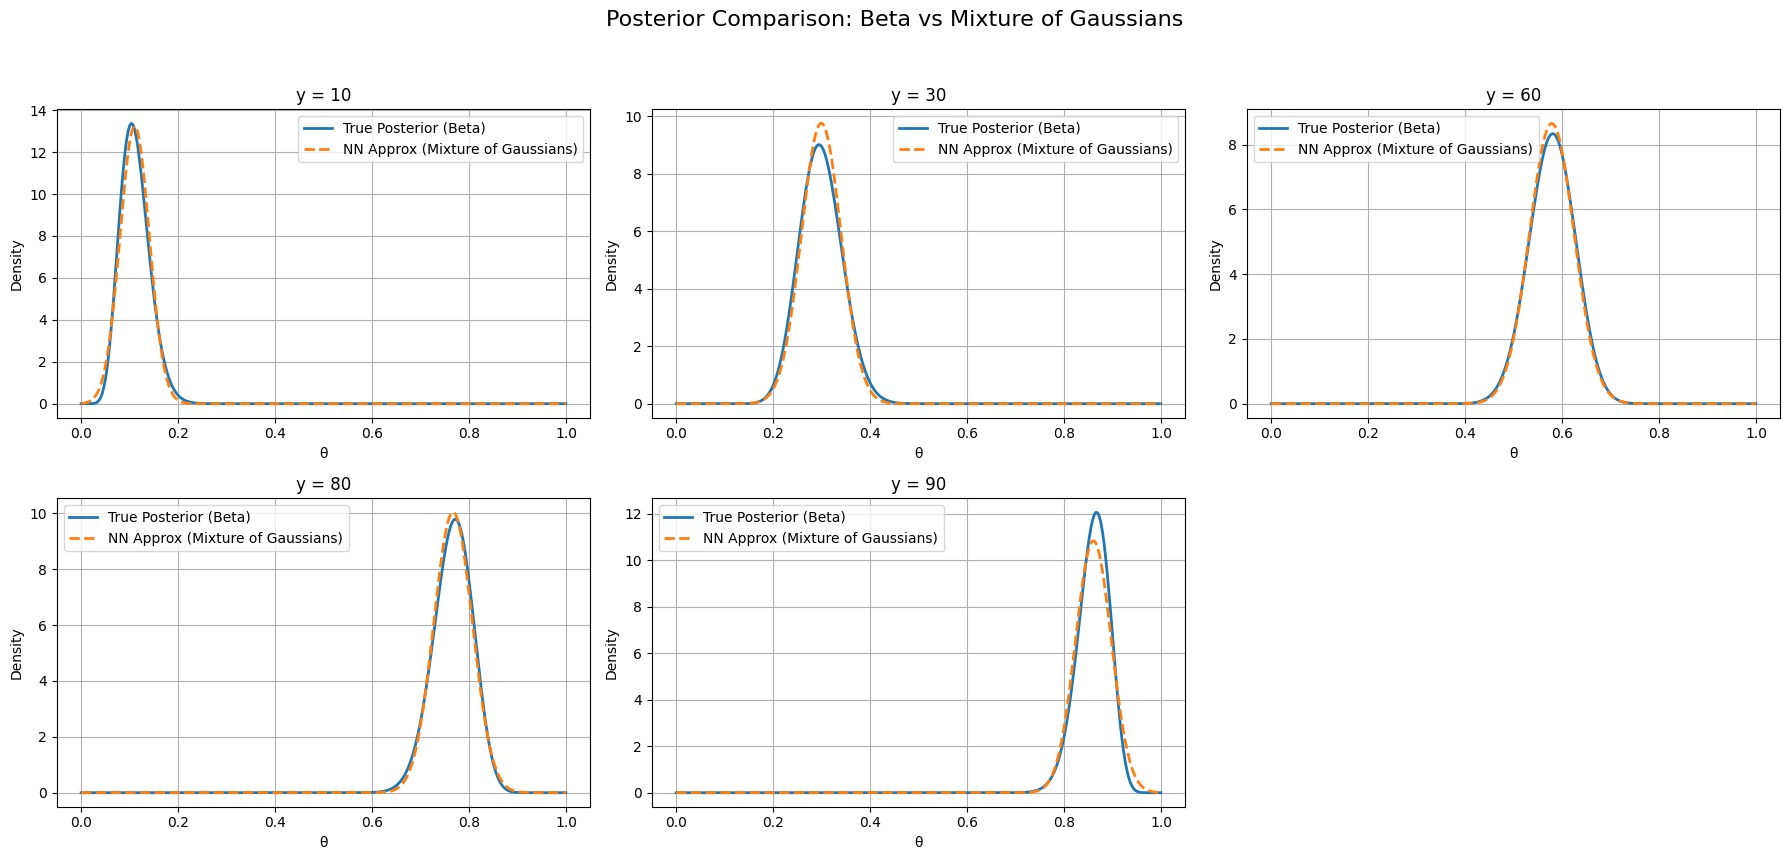

In [21]:
import math
import matplotlib.pyplot as plt
from scipy.stats import beta, norm

# List of y values to visualize
y_obs_list = [10, 30, 60, 80, 90]
n_cols = 3
n_rows = math.ceil(len(y_obs_list) / n_cols)

theta_range = np.linspace(0.001, 0.999, 300)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for idx, y_obs in enumerate(y_obs_list):
    x_test = torch.tensor([[y_obs / n_trials]], dtype=torch.float32)

    with torch.no_grad():
        weights, mu, log_var = model(x_test)
    # True posterior
    true_post = beta(a=alpha + y_obs, b=beta_para + n_trials - y_obs)
    true_pdf = true_post.pdf(theta_range)

    # Mixture of Gaussians approximation
    approx_pdf = np.zeros_like(theta_range)
    K = weights.shape[1]
    for k in range(K):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = np.sqrt(np.exp(log_var[0, k].item()))
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    # Plot
    ax = axes[idx]
    ax.plot(theta_range, true_pdf, label="True Posterior (Beta)", lw=2)
    ax.plot(theta_range, approx_pdf, label="NN Approx (Mixture of Gaussians)", lw=2, linestyle="--")
    ax.set_title(f"y = {y_obs}", fontsize=12)
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(len(y_obs_list), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Posterior Comparison: Beta vs Mixture of Gaussians", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### DNN Inference for Gamma Using Mixture_Gaussian

Now we use the same idea from beta example, except that our y are sampled from possion distribution

In [ ]:
from scipy.stats import norm, poisson, beta, binom,gamma,poisson
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import random



# Set seed value
SEED = 123
random.seed(SEED)         # Python random
np.random.seed(SEED)      # NumPy random
torch.manual_seed(SEED)   # PyTorch random

# For reproducibility (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




# Define the deep neural network
class MixtureDensityNN(nn.Module):
    def __init__(self, K=8):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(1, 24),
            nn.ReLU(),
            nn.Linear(24 ,25),
            nn.ReLU(),
            nn.Linear(25, 16),
            nn.ReLU(),
        )
        #  the logits need to sum up to 1 , so we must apply a softmax
        self.logits_head = nn.Linear(16, K)      # raw logits → softmax - I've edited it , no longer softmaxxs
        self.mu_head = nn.Linear(16, K)          # component means
        self.log_var_head = nn.Linear(16, K)     # component log-variances

    def forward(self, x):
        h = self.backbone(x)                        # h represents hidden layer, it has 32 units, contaning the information
        logits = self.logits_head(h)             # shape: (B, K)
        weights = torch.softmax(logits, dim=-1)  # shape: (B, K)

        mu = self.mu_head(h)                     # shape: (B, K)
        log_var = self.log_var_head(h)           # shape: (B, K)

        return weights, mu, log_var

    

# the prior is Gamma distribution
alpha = 2
beta_para = 3

# number of samples
M = 10**6
#-------------------------------------------------------------------------------------------


# Gamma distribution

n_trials = 100

# First sample theta form Beta(2,5)
theta_samples = gamma.rvs(a = alpha, loc=0, scale = 1/beta_para, size=M)


# Broadcasting over theta_samples
y_samples = np.sum(poisson.rvs(mu=theta_samples[:, None], size=(len(theta_samples), n_trials)), axis=1)



theta_np = theta_samples.reshape(-1,1)
y_np = y_samples.reshape(-1,1)


# Combine  theta_np and y_np together
out_mat = np.column_stack([theta_samples, y_samples])
# Create a list of theta

#----------------------------------------------------------------------------------------


theta_dict = defaultdict(list)
sel_index = (out_mat[:, 1] == 1) 
# Find the unique y_vals
unique_y_vals = np.unique(out_mat[:, 1])
# print(sel_index)
for y in unique_y_vals:
    sel_index = (out_mat[:, 1] == y)
    theta_vals = out_mat[sel_index, 0]
    theta_dict[y] = theta_vals



# Now calculate the mean and variance of theta list
post_means = {}
post_vars = {}

for i in theta_dict:
    if len(theta_dict[i]) >=2:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = np.var(thetas)
    elif len(theta_dict[i]) == 1:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = 0
    else:
        post_means[i] = 0
        post_vars[i] = 0
        
# print(post_means)
# print(post_vars)

for key in theta_dict:
    if len(theta_dict[key]) == 0:
        theta_dict[key] = np.array([0.0])



# Define what our optimizer is
model = MixtureDensityNN(K=8)

optimizer = optim.Adam(model.parameters(), lr=0.01)

#=================
def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    """
    theta_vals: (N, 1)
    weights, mu, log_var: (1, K)
    Return: scalar negative log-likelihood
    """
    var = torch.exp(log_var)  # shape: (1, K)
    std = torch.sqrt(var)

    # Expand theta: (N, 1) → (N, K)
    theta = theta_vals.expand(-1, mu.shape[1])  # (N, K)

    # Compute Gaussian log probs: shape (N, K)
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta - mu)**2 / var)

    # Weighted log sum exp over K components
    log_weighted_probs = torch.log(weights) + log_probs
    log_sum = torch.logsumexp(log_weighted_probs, dim=1)  # shape: (N,)

    return -log_sum.mean()
#=================
for epoch in range(1000):
    model.train()  
    total_loss = 0.0  # Accumulate total loss across all y values

    # Loop over all possible y values (from 0 to n_trials)
    for i in range(n_trials + 1):
        if post_vars[i] == 0:
            continue  # Skip y values with no corresponding theta samples

        # Normalize y value (scale to [0, 1]) and convert to tensor
        x_input = torch.tensor([[i / n_trials]], dtype=torch.float32)

        # Forward pass: predict mixture parameters for current y
        # weights: (1, K) → mixture weights (pi_k), sum to 1
        # mu: (1, K) → means of each Gaussian component
        # log_var: (1, K) → log-variances for numerical stability
        weights, mu, log_var = model(x_input)

        # Get the θ samples for current y, reshape to (N, 1)
        theta_vals = torch.tensor(theta_dict[i], dtype=torch.float32).view(-1, 1)

        # Compute the negative log-likelihood under the mixture model
        # This function handles the log-sum-exp across K components
        loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)

        # Accumulate loss over all y values
        total_loss += loss_i

    # Backward pass: compute gradients and update model parameters
    loss = total_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")



Epoch 0, Loss: 109.27053
Epoch 100, Loss: -130.26508
Epoch 200, Loss: -135.29329
Epoch 300, Loss: -137.42159
Epoch 400, Loss: -136.31226
Epoch 500, Loss: -127.85307
Epoch 600, Loss: -138.42549
Epoch 700, Loss: -138.72403
Epoch 800, Loss: -102.91736
Epoch 900, Loss: -138.06847


### Plot Gamma Result

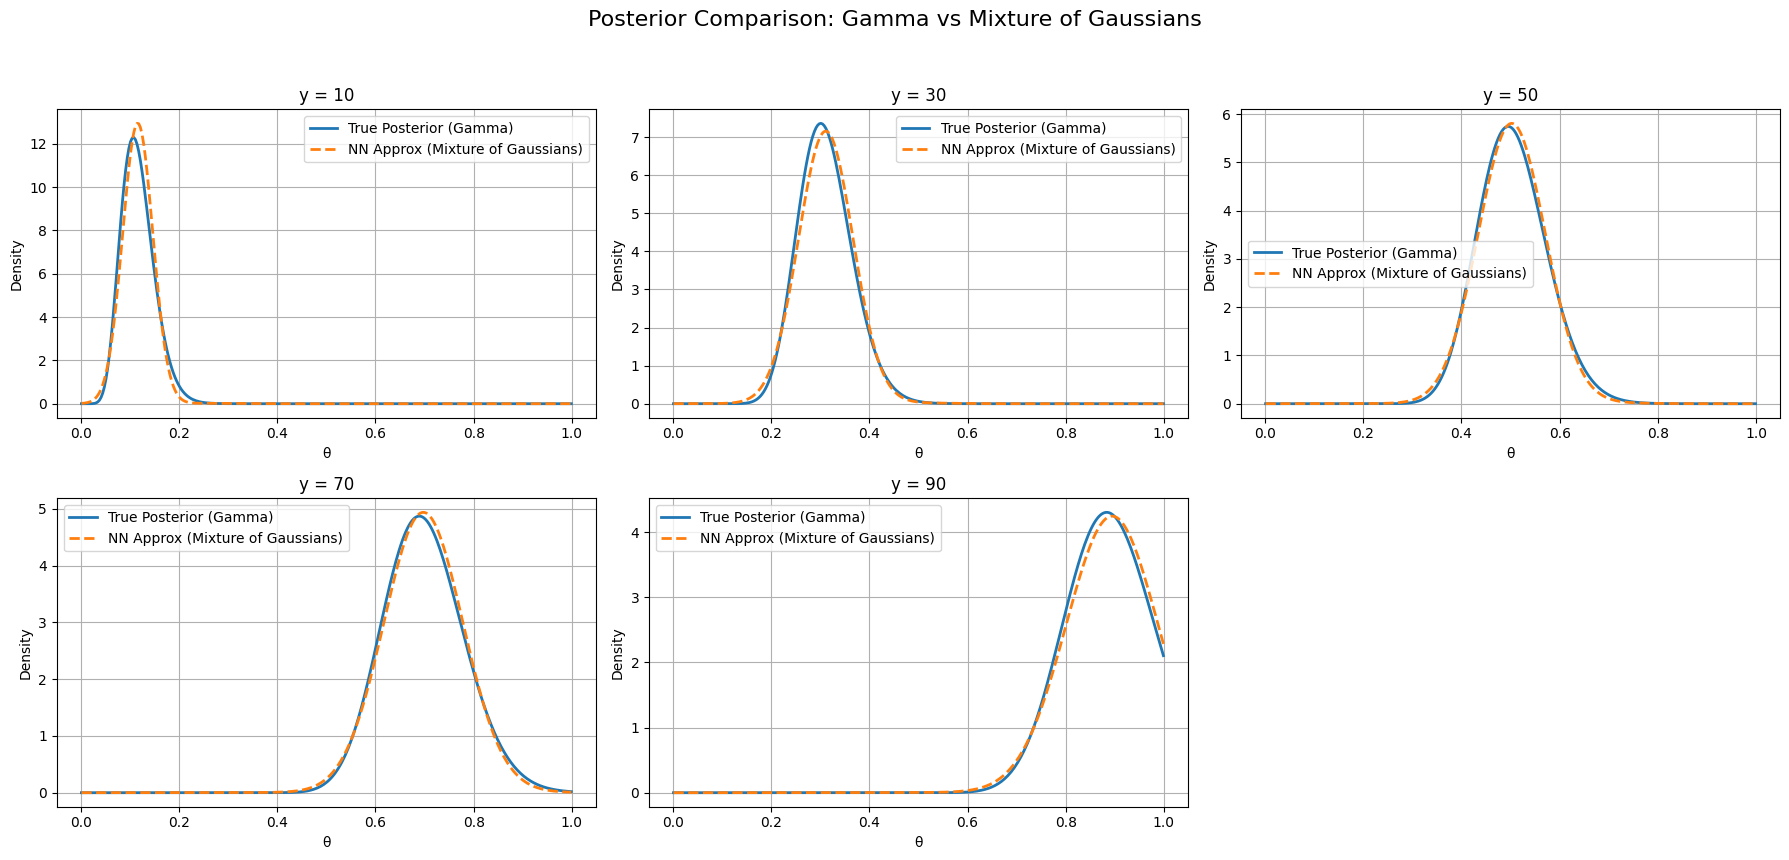

In [26]:
import math
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# List of y values to test
y_obs_list = [10, 30, 50, 70, 90]
n_cols = 3
n_rows = math.ceil(len(y_obs_list) / n_cols)

theta_range = np.linspace(0.001, 0.999, 300)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for idx, y_obs in enumerate(y_obs_list):
    x_test = torch.tensor([[y_obs / n_trials]], dtype=torch.float32)


    with torch.no_grad():
        weights, mu, log_var = model(x_test)

    # True posterior: Gamma(α + y, scale = 1 / (β + n))
    true_post = gamma(a=alpha + y_obs, scale=1 / (beta_para + n_trials))
    true_pdf = true_post.pdf(theta_range)

    # Mixture of Gaussians approximation
    approx_pdf = np.zeros_like(theta_range)
    K = weights.shape[1]
    for k in range(K):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = np.sqrt(np.exp(log_var[0, k].item()))
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    # Plot
    ax = axes[idx]
    ax.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    ax.plot(theta_range, approx_pdf, label="NN Approx (Mixture of Gaussians)", lw=2, linestyle="--")
    ax.set_title(f"y = {y_obs}", fontsize=12)
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(len(y_obs_list), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Posterior Comparison: Gamma vs Mixture of Gaussians", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Official comparing between MOG and Single Gaussian

#### Define the necessary component first

In [27]:
# models.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, beta,gamma

class ProbabilisticNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4 ,1)
        )
        self.log_var_net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        mu = self.mean_net(x)  # no constraint, output unrestricted
        log_var = self.log_var_net(x)
        return mu, log_var

class MixtureDensityNN(nn.Module):
    def __init__(self, K=3):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.logits_head = nn.Linear(32, K)
        self.mu_head = nn.Linear(32, K)  # no activation constraint
        self.log_var_head = nn.Linear(32, K)

    def forward(self, x):
        h = self.backbone(x)
        weights = torch.softmax(self.logits_head(h), dim=-1)
        mu = self.mu_head(h)  # unrestricted
        log_var = self.log_var_head(h)
        return weights, mu, log_var

def get_model(model_type='mog', K=3):
    if model_type == 'mog':
        return MixtureDensityNN(K=K)
    elif model_type == 'normal':
        return ProbabilisticNN()
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

# ---------- Training and Testing Utilities ----------

def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    var = torch.exp(log_var)
    theta = theta_vals.expand(-1, mu.shape[1])  # (N, K)
    log_probs = -0.5 * (log_var + torch.log(torch.tensor(2 * torch.pi)) + (theta - mu) ** 2 / var)
    weighted_log_probs = torch.log(weights) + log_probs
    log_likelihoods = torch.logsumexp(weighted_log_probs, dim=1)
    return -log_likelihoods.mean()

def train_model(model, optimizer, theta_dict, post_vars, model_type='mog', n_trials=100, epochs=1000):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for y in range(n_trials + 1):
            if post_vars[y] == 0:
                continue
            x_input = torch.tensor([[y / n_trials]], dtype=torch.float32)
            theta_vals = torch.tensor(theta_dict[y], dtype=torch.float32).view(-1, 1)

            if model_type == 'mog':
                weights, mu, log_var = model(x_input)
                loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)
            elif model_type == 'normal':
                mu, log_var = model(x_input)
                var = torch.exp(log_var)
                log_probs = -0.5 * (torch.log(torch.tensor(2 * torch.pi)) + log_var + (theta_vals - mu)**2 / var)
                loss_i = -log_probs.mean()
            else:
                raise ValueError("Invalid model_type")

            total_loss += loss_i

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")

def test_model(model, y_obs, model_type='mog', n_trials=100):
    model.eval()
    x_test = torch.tensor([[y_obs / n_trials]], dtype=torch.float32)
    with torch.no_grad():
        if model_type == 'mog':
            weights, mu, log_var = model(x_test)
            return weights[0], mu[0], log_var[0]  # Return 1D tensors
        elif model_type == 'normal':
            mu, log_var = model(x_test)
            return mu[0, 0].item(), log_var[0, 0].item()
        else:
            raise ValueError("Invalid model_type")

# ---------- Plot Posterior Comparison for Multiple y ----------
def plot_posterior_comparisons(model_mog, model_normal, alpha, beta_para, n_trials, y_list):
    theta_range = np.linspace(0.001, 0.999, 300)
    for y_obs in y_list:
        # True posterior
        true_posterior = beta(a=alpha + y_obs, b=beta_para + n_trials - y_obs)
        true_pdf = true_posterior.pdf(theta_range)

        # MoG output
        weights, mu_mog, log_var_mog = test_model(model_mog, y_obs, model_type='mog', n_trials=n_trials)
        approx_pdf_mog = np.zeros_like(theta_range)
        K = weights.shape[0]
        for k in range(K):
            pi_k = weights[k].item()
            mu_k = mu_mog[k].item()
            std_k = np.sqrt(np.exp(log_var_mog[k].item()))
            approx_pdf_mog += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

        # Normal output
        mu_normal, log_var_normal = test_model(model_normal, y_obs, model_type='normal', n_trials=n_trials)
        std_val = np.sqrt(np.exp(log_var_normal))
        approx_pdf_normal = norm.pdf(theta_range, loc=mu_normal, scale=std_val)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(theta_range, true_pdf, label="True Posterior (Beta)", lw=2)
        plt.plot(theta_range, approx_pdf_mog, label="NN Posterior (Mixture of Gaussians)", lw=2, linestyle="--")
        plt.plot(theta_range, approx_pdf_normal, label="NN Posterior (Single Gaussian)", lw=2, linestyle=":")
        plt.title(f"Posterior Comparison for y = {y_obs}")
        plt.xlabel("θ")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        
        
def plot_gamma_posterior_comparisons(model_mog, model_normal, alpha, beta_para, n_trials, y_list):
    theta_range = np.linspace(0.001, 0.999, 300)
    for y_obs in y_list:
        # Gamma posterior
        true_posterior = gamma(a=alpha + y_obs, scale=1 / (beta_para + n_trials))
        true_pdf = true_posterior.pdf(theta_range)

        # MoG model output
        weights, mu_mog, log_var_mog = test_model(model_mog, y_obs, model_type='mog', n_trials=n_trials)
        approx_pdf_mog = np.zeros_like(theta_range)
        K = weights.shape[0]
        for k in range(K):
            pi_k = weights[k].item()
            mu_k = mu_mog[k].item()
            std_k = np.sqrt(np.exp(log_var_mog[k].item()))
            approx_pdf_mog += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

        # Normal model output
        mu_normal, log_var_normal = test_model(model_normal, y_obs, model_type='normal', n_trials=n_trials)
        std_val = np.sqrt(np.exp(log_var_normal))
        approx_pdf_normal = norm.pdf(theta_range, loc=mu_normal, scale=std_val)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
        plt.plot(theta_range, approx_pdf_mog, label="NN Posterior (Mixture of Gaussians)", lw=2, linestyle="--")
        plt.plot(theta_range, approx_pdf_normal, label="NN Posterior (Single Gaussian)", lw=2, linestyle=':')
        plt.title(f"Posterior Comparison for y = {y_obs}")
        plt.xlabel("θ")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()


### Comparing MOG of Beta and Single Gaussian of Beta

Epoch 0, Loss: 109.22644
Epoch 100, Loss: -182.29205
Epoch 200, Loss: -184.75011
Epoch 300, Loss: -133.16907
Epoch 400, Loss: -186.41446
Epoch 500, Loss: -187.00410
Epoch 600, Loss: -182.25357
Epoch 700, Loss: -160.03654
Epoch 800, Loss: -188.03447
Epoch 900, Loss: -188.54408
Epoch 0, Loss: 1143444.25000
Epoch 100, Loss: -1751963.25000
Epoch 200, Loss: -1791714.37500
Epoch 300, Loss: -1809319.25000
Epoch 400, Loss: -1824845.37500
Epoch 500, Loss: -1841419.87500
Epoch 600, Loss: -1826521.25000
Epoch 700, Loss: -1850612.00000
Epoch 800, Loss: -1850148.12500
Epoch 900, Loss: -1856082.25000


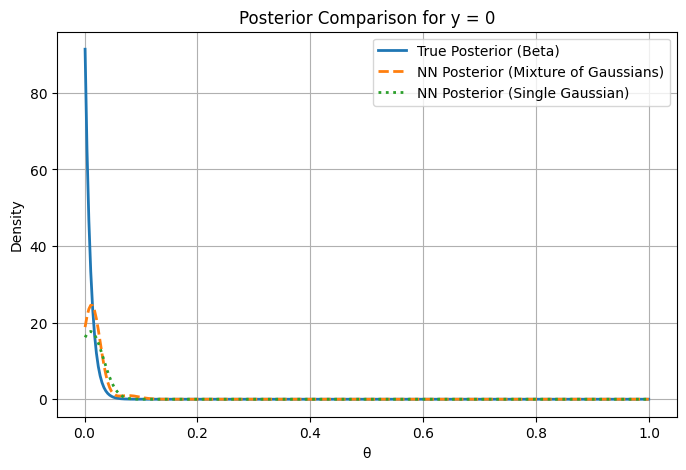

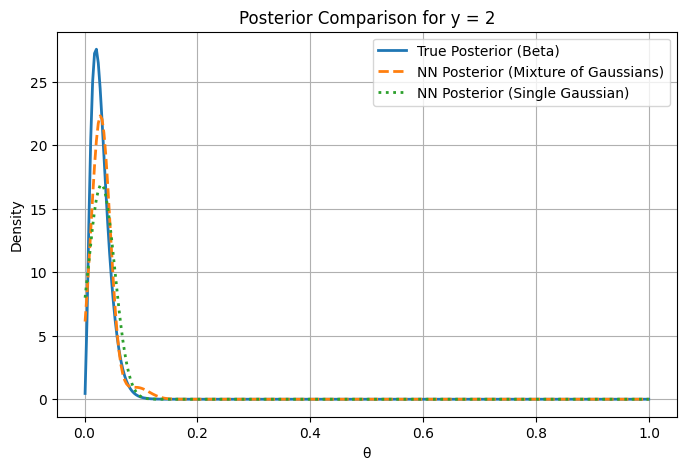

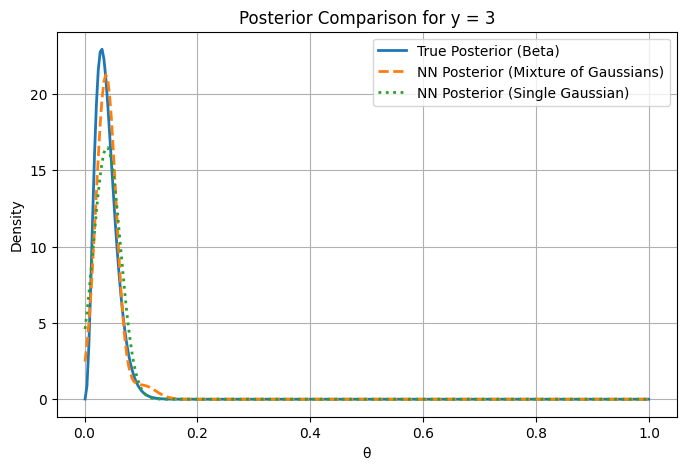

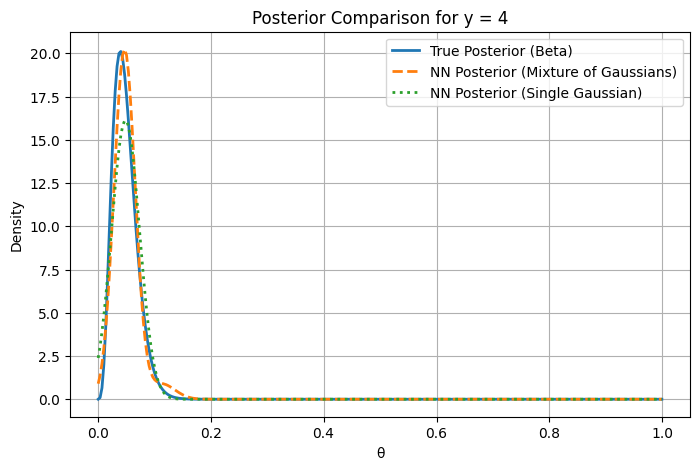

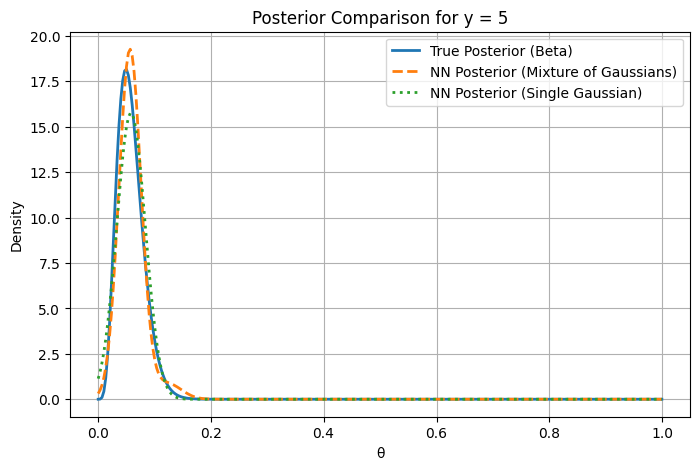

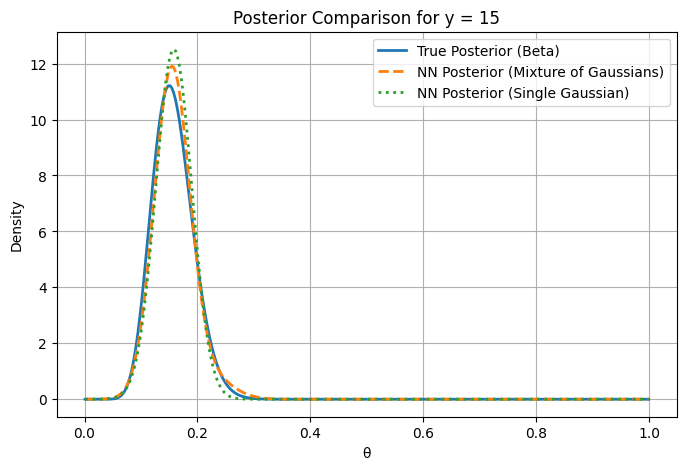

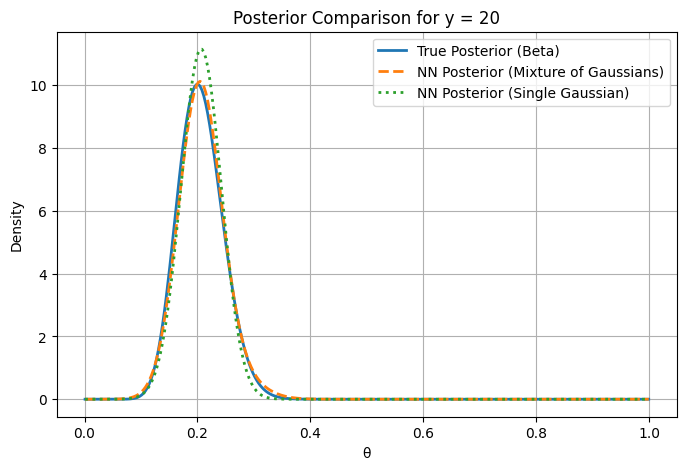

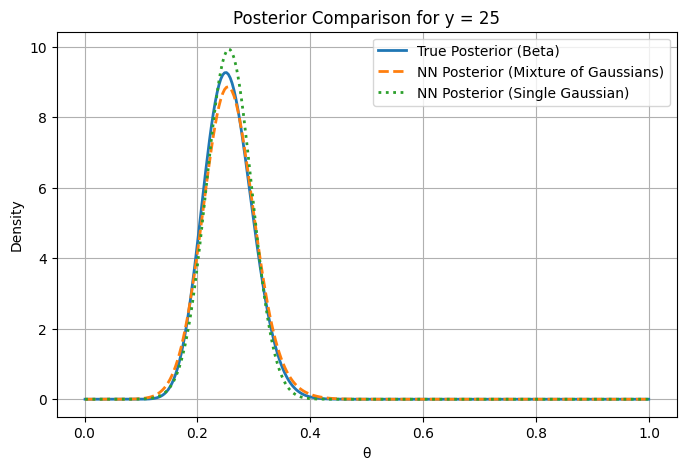

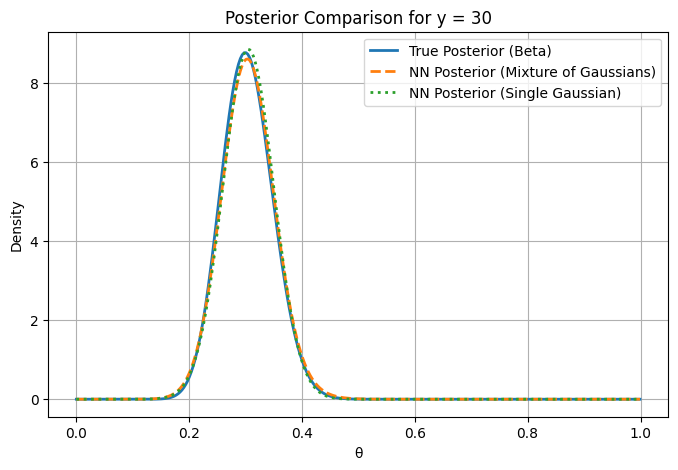

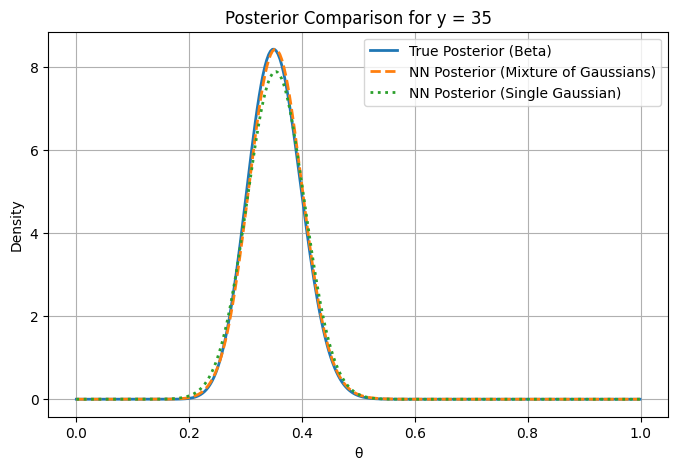

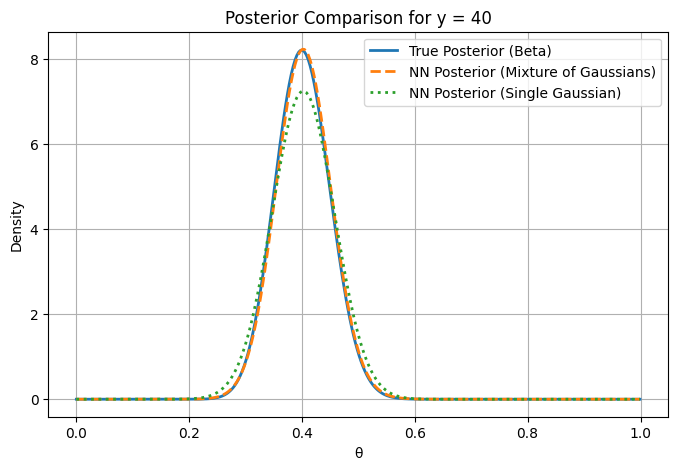

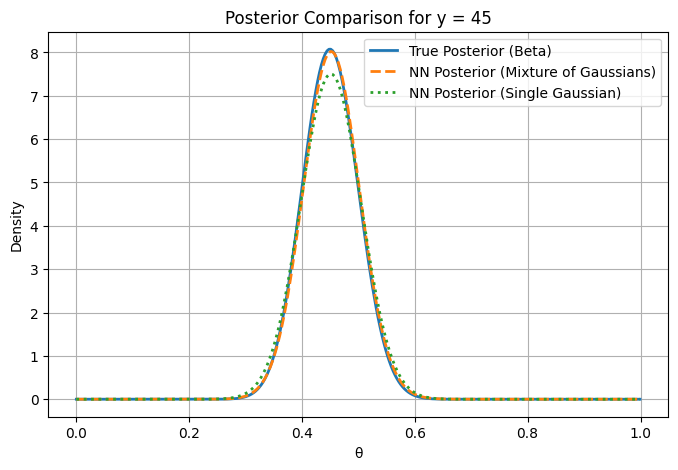

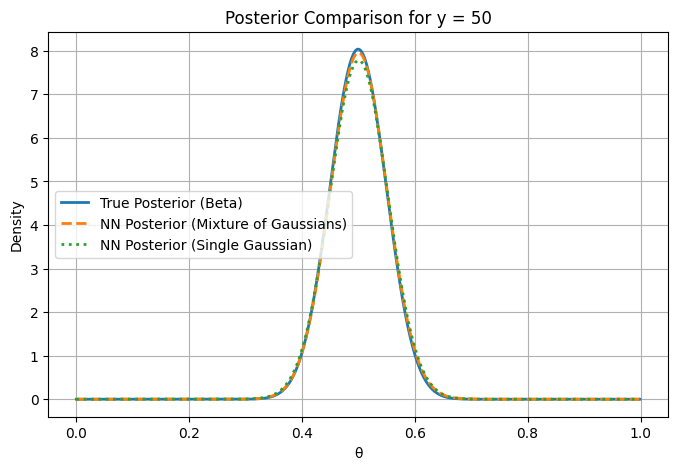

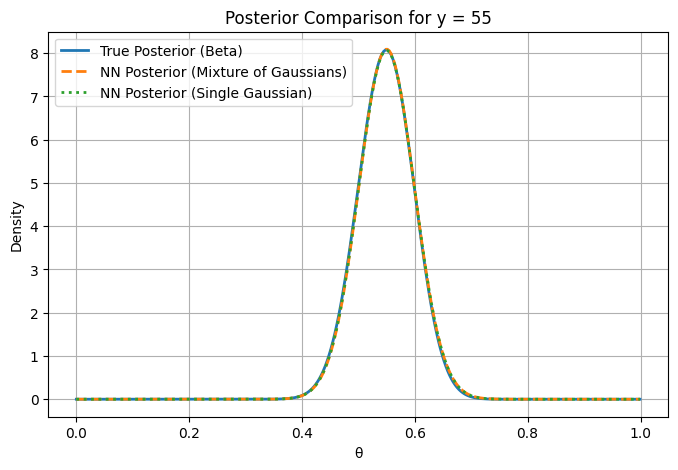

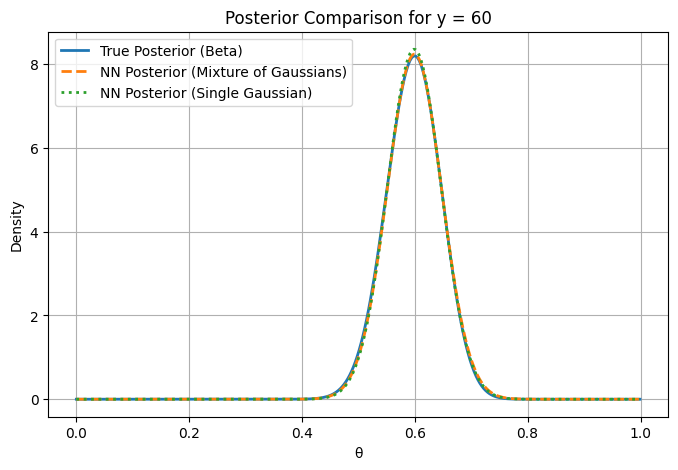

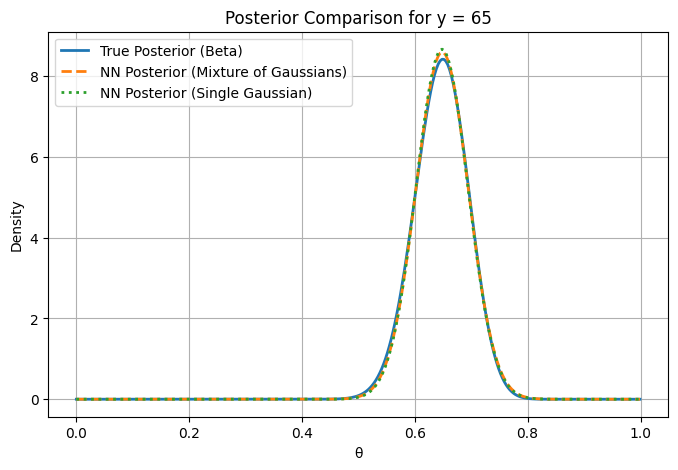

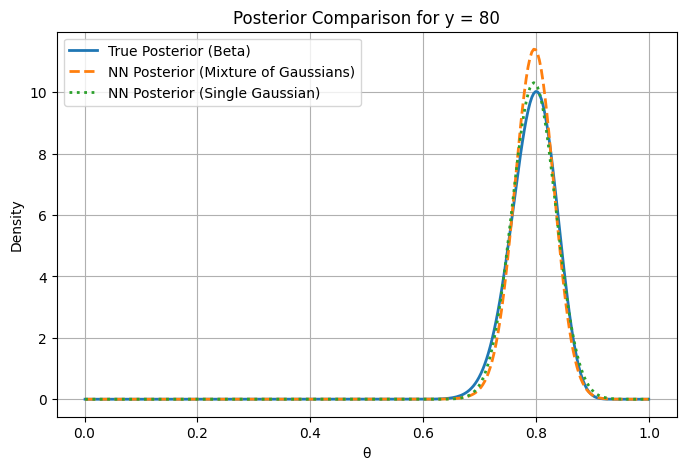

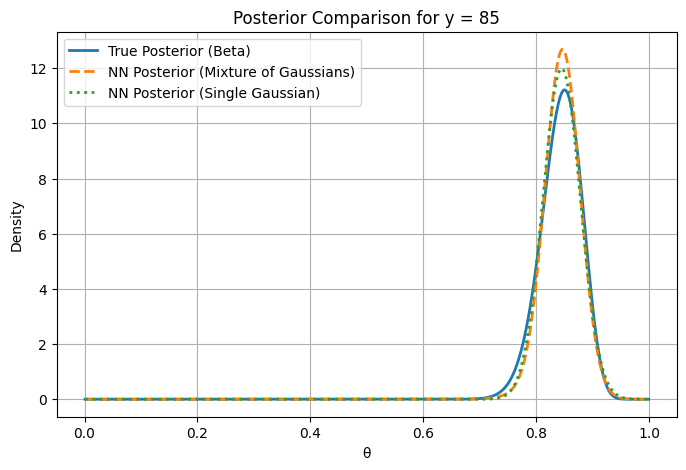

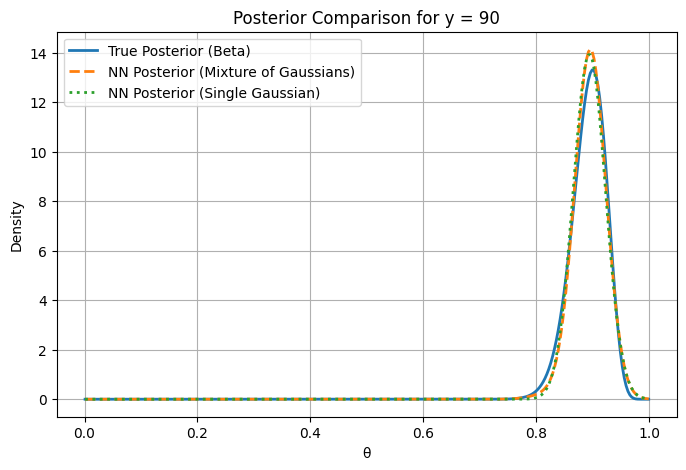

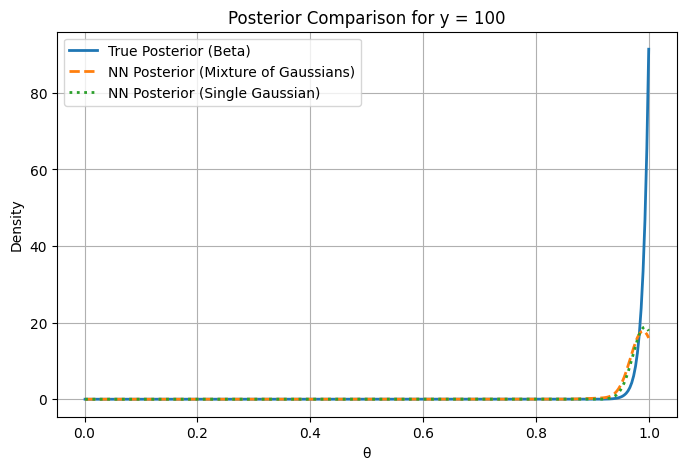

In [29]:
# %% Imports and config
from scipy.stats import norm, poisson, beta, binom
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import random

# %% Imports and config




# %% Data generation
# Set seed value
SEED = 123
random.seed(SEED)         # Python random
np.random.seed(SEED)      # NumPy random
torch.manual_seed(SEED)   # PyTorch random

# For reproducibility (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# the prior is beta distribution
alpha = 1
beta_para = 1

# number of samples
M = 10**6
#-------------------------------------------------------------------------------------------

# binomial distribution
n_trials = 100

# First sample theta form Beta(2,5)
theta_samples = beta.rvs(alpha, beta_para, size=M)
# Then for each theta, generate the binomial , also 

y_samples = binom.rvs(n=n_trials, p = theta_samples)

# Now you have (θ, x) pairs
# print("First 5 theta values:", theta_samples[:5])
# print("First 5 x values:", y_samples[:5])

theta_np = theta_samples.reshape(-1,1)
y_np = y_samples.reshape(-1,1)


# Combine  theta_np and y_np together
out_mat = np.column_stack([theta_samples, y_samples])


#----------------------------------------------------------------------------------------

# Create a list of theta
theta_dict = defaultdict(list)
sel_index = (out_mat[:, 1] == 1) 
# Find the thetas based on unique y
for i in range(n_trials + 1):  # y ∈ [0, n_trials]
    sel_index = (out_mat[:, 1] == i)         # select rows where y == i
    theta_vals = out_mat[sel_index, 0]       # get corresponding θ
    theta_dict[i] = theta_vals               # store as list or array


# Now calculate the mean and variance of theta list
post_means = {}
post_vars = {}

for i in theta_dict:
    if len(theta_dict[i]) >=2:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = np.var(thetas)
    elif len(theta_dict[i]) == 1:
        thetas = np.array(theta_dict[i])
        post_means[i] = np.mean(thetas)
        post_vars[i] = 0
    else:
        post_means[i] = 0
        post_vars[i] = 0
        
for key in theta_dict:
    if len(theta_dict[key]) == 0:
        theta_dict[key] = np.array([0.0])

# %% Train MoG model
# Define what our optimizer is
model_1 = get_model(model_type='mog', K=8)

optimizer = optim.Adam(model_1.parameters(), lr=0.01)


for epoch in range(1000):
    model_1.train()  
    total_loss = 0.0  # Accumulate total loss across all y values

    # Loop over all possible y values (from 0 to n_trials)
    for i in range(n_trials + 1):
        if post_vars[i] == 0:
            continue  # Skip y values with no corresponding theta samples

        # Normalize y value (scale to [0, 1]) and convert to tensor
        x_input = torch.tensor([[i / n_trials]], dtype=torch.float32)

        # Forward pass: predict mixture parameters for current y
        # weights: (1, K) → mixture weights (pi_k), sum to 1
        # mu: (1, K) → means of each Gaussian component
        # log_var: (1, K) → log-variances for numerical stability
        weights, mu, log_var = model_1(x_input)

        # Get the θ samples for current y, reshape to (N, 1)
        theta_vals = torch.tensor(theta_dict[i], dtype=torch.float32).view(-1, 1)

        # Compute the negative log-likelihood under the mixture model
        # This function handles the log-sum-exp across K components
        loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)

        # Accumulate loss over all y values
        total_loss += loss_i

    # Backward pass: compute gradients and update model parameters
    loss = total_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")
# %% Train Normal model

model_2 = get_model(model_type='normal', K=3)

optimizer = optim.Adam(model_2.parameters(), lr=0.01)


for epoch in range(1000):
    model_2.train()
    total_log_likelihood = 0.0

    for i in range(n_trials + 1):
        if post_vars[i] == 0:
            continue

        x_input = torch.tensor([[i / n_trials]], dtype=torch.float32)

        mu_pred, log_var_pred = model_2(x_input)
        var_pred = torch.exp(log_var_pred)

        theta_vals = torch.tensor(theta_dict[i], dtype=torch.float32).view(-1, 1)

        log_probs = -0.5 * (torch.log((torch.tensor(2 * torch.pi)) )
                            + log_var_pred 
                            + (theta_vals - mu_pred) 
                            ** 2 / var_pred)

        total_log_likelihood += log_probs.sum()

    loss = -total_log_likelihood

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")
# %% Test Results
y_obs = 60

# MoG output
weights, mu_mog, log_var_mog = test_model(model_1, y_obs, model_type='mog', n_trials=n_trials)

# Normal output
mu_normal, log_var_normal = test_model(model_2, y_obs, model_type='normal', n_trials=n_trials)




# %% Visualization and comparison
plot_posterior_comparisons(
    model_mog=model_1,
    model_normal=model_2,
    alpha=1,
    beta_para=1,
    n_trials=100,
    y_list=[0,2,3,4,5, 15, 20, 25,30, 35, 40,45,50,55, 60,65, 80,85,90, 100]
)



### Comparing MOG of Gamma and Single Gaussian of Gamma